# Climate Risk Premium Analysis: Data Cleaning & Feature Engineering

**Project**: Analyzing Climate Risk Premiums in US Equity Markets  
**Notebook**: 2. Data Cleaning & Feature Engineering  
**Author**: Anush Nepal

## Objective
Transform raw stock price data into analysis-ready features for climate risk analysis:
- Calculate **daily returns** and **volatility measures**
- Create **event windows** around climate events
- Generate **sector performance metrics**
- Prepare data for **event study analysis**

## Data Overview
Starting with **90,495 records** from **45 companies** across 3 climate-sensitive sectors (2017-2024).

## 1. Importing Libraries & Loading Data
Loading cleaned dataset and setting up the analysis environment.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
print("Libraries imported successfully.")
print(f"Analysis date: {datetime.now().strftime('%Y-%m-%d')}")

Libraries imported successfully.
Analysis date: 2025-08-18


In [4]:
print("Loading dataset...")
df = pd.read_csv('../data/raw/complete_stock_data.csv') # Loading main stock data
events_df = pd.read_csv('../data/raw/climate_events.csv') # Loading climate events
df['Date'] = pd.to_datetime(df['Date'])
events_df['Date'] = pd.to_datetime(events_df['Date'])
print(f"- Stock data loaded : {df.shape}")
print(f"- Climate events loaded: {events_df.shape}")
print(f"- Date range: {df['Date'].min().date()} to {df['Date'].max().date()}")
print(f"- Companies: {df['Ticker'].nunique()}")
print(f"- Sectors: {', '.join(df['Sector'].unique())}")

Loading dataset...
- Stock data loaded : (90495, 10)
- Climate events loaded: (7, 4)
- Date range: 2017-01-03 to 2024-12-30
- Companies: 45
- Sectors: Energy, Insurance, Real Estate


## 2. Data Preparation & Cleaning
Ensuring the data is properly formatted and handling any edge cases, before analysis.

In [5]:
print("Preparing data for analysis...")
df = df.sort_values(['Ticker', 'Date']).reset_index(drop=True)
print("Converting date columns...") # Converting Date column from text to proper datetime
df['Date'] = pd.to_datetime(df['Date'], utc=True).dt.tz_localize(None)
events_df['Date'] = pd.to_datetime(events_df['Date'])

# Removing timezone from events if it exists
if hasattr(events_df['Date'].dtype, 'tz') and events_df['Date'].dt.tz is not None:
    events_df['Date'] = events_df['Date'].dt.tz_localize(None)
print(f"- Date conversion successful")
print(f"- df['Date'] dtype: {df['Date'].dtype}")
print(f"- events_df['Date'] dtype: {events_df['Date'].dtype}")

print("\nDate Integrity Check:")
records_per_company = df.groupby('Ticker').size()
print(f"- Records per company: {records_per_company.describe().round(0)}")
print(f"- Price columns, any negatives? {(df[['Open', 'High', 'Low', 'Close']] < 0).any().any()}")
print(f"- Volume, any negatives? {(df['Volume'] < 0).any()}")

price_check = (
    (df['High'] >= df['Low']) &
    (df['Close'] <= df['High']) &
    (df['Close'] >= df['Low'])
).all()
print(f"- Price consistency check: {'Passed' if price_check else 'Failed'}")

print("\nSample of cleaned data:")
display_cols = ['Date', 'Ticker', 'Sector', 'Open', 'Close', 'Volume']
print(df[display_cols].head(10))

Preparing data for analysis...
Converting date columns...
- Date conversion successful
- df['Date'] dtype: datetime64[ns]
- events_df['Date'] dtype: datetime64[ns]

Date Integrity Check:
- Records per company: count     45.0000
mean    2011.0000
std        0.0000
min     2011.0000
25%     2011.0000
50%     2011.0000
75%     2011.0000
max     2011.0000
dtype: float64
- Price columns, any negatives? False
- Volume, any negatives? False
- Price consistency check: Failed

Sample of cleaned data:
                 Date Ticker     Sector    Open   Close  Volume
0 2017-01-03 05:00:00    AFG  Insurance 45.1676 44.8207  210100
1 2017-01-04 05:00:00    AFG  Insurance 44.9738 45.2901  339500
2 2017-01-05 05:00:00    AFG  Insurance 45.2748 44.8105  212400
3 2017-01-06 05:00:00    AFG  Insurance 44.7901 44.8105  152700
4 2017-01-09 05:00:00    AFG  Insurance 44.8514 44.2545  157800
5 2017-01-10 05:00:00    AFG  Insurance 44.3973 44.4484  185700
6 2017-01-11 05:00:00    AFG  Insurance 44.4857 44.9158

In [6]:
print("Investigating price consistency...")
price_issues = df[
    (df['High'] < df['Low']) |  # High should be >= Low
    (df['Close'] > df['High']) |  # Close should be <= High  
    (df['Close'] < df['Low'])     # Close should be >= Low
]
print(f"Records with price issues: {len(price_issues)}")

if len(price_issues) > 0:
    print("\nFirst few problematic records:")
    print(price_issues[['Date', 'Ticker', 'Open', 'High', 'Low', 'Close']].head())
    high_low_issues = len(df[df['High'] < df['Low']]) # Checking type of issues
    close_high_issues = len(df[df['Close'] > df['High']])
    close_low_issues = len(df[df['Close'] < df['Low']])
    print(f"\nTypes of issues:")
    print(f"- High < Low: {high_low_issues} records")
    print(f"- Close > High: {close_high_issues} records") 
    print(f"- Close < Low: {close_low_issues} records")
    print(f"\nTotal problematic records: {len(price_issues)} out of {len(df)} ({len(price_issues)/len(df)*100:.4f}%)")
    
    if len(price_issues) < 100:  # If very few issues
        print("- Very small number of issues--safe to remove these records")
        df_clean = df[~df.index.isin(price_issues.index)].copy()
        print(f"- Cleaned dataset: {len(df_clean)} records (removed {len(price_issues)})")
        df = df_clean # Updating  main dataframe
        price_check_new = ( # Rechecking
            (df['High'] >= df['Low']) & 
            (df['Close'] <= df['High']) & 
            (df['Close'] >= df['Low'])
        ).all()
        print(f"- Price consistency check after cleaning: {'Passed' if price_check_new else 'Still Failed'}")
    
else:
    print("No price issues found.")

print(f"\nFinal dataset size: {len(df):,} records")

Investigating price consistency...
Records with price issues: 26

First few problematic records:
                    Date Ticker     Open     High      Low    Close
269  2018-01-29 05:00:00    AFG  61.4468  61.8387  61.1086  61.1086
627  2019-07-02 04:00:00    AFG  59.0735  59.3305  58.7022  59.3305
694  2019-10-07 04:00:00    AFG  59.6032  59.6204  59.0872  59.0872
794  2020-03-02 05:00:00    AFG  54.8342  57.2561  54.2933  57.2561
8568 2019-02-04 05:00:00    ARE 103.6642 104.1095 102.8532 104.1095

Types of issues:
- High < Low: 0 records
- Close > High: 15 records
- Close < Low: 11 records

Total problematic records: 26 out of 90495 (0.0287%)
- Very small number of issues--safe to remove these records
- Cleaned dataset: 90469 records (removed 26)
- Price consistency check after cleaning: Passed

Final dataset size: 90,469 records


## 3. Calculating Daily Returns
Daily returns are the foundation of financial analysis, and so, we'll calculate both simple and log returns for each stock.

In [7]:
print("Calculating daily returns...")
def calculate_returns(group):
    """
    Calculating daily returns for a single stock.

    Simple Return = (Price_today - Price_yesterday) / Price_yesterday
    Log Return = ln (Price_today / Price_yesterday)
    """
    group = group.sort_values('Date') # Sorting by date to ensure proper order
    group['Daily_Return'] = group['Close'].pct_change() # Calculating simple daily returns
    group['Log_Return'] = np.log(group['Close'] / group['Close'].shift(1)) # Calcualting log returns (better for statistical analysis)
    group['Intraday_Volatility'] = (group['High'] - group['Low']) / group['Close']
    return group

df = df.groupby('Ticker').apply(calculate_returns).reset_index(drop=True) # Applying return calculations to each stock
df = df.dropna(subset=['Daily_Return']).reset_index(drop=True) # Removing first day for each stock (no return calculation possible)
print(f"- Returns calculated for {df['Ticker'].nunique()} stocks")
print(f"- Total records with returns: {len(df):,}")

print("\nDaily Return Statistics:")
return_stats = df.groupby('Sector')['Daily_Return'].agg(['count', 'mean', 'std', 'min', 'max']).round(4)
return_stats.columns = ['Count', 'Mean_Return', 'Volatility', 'Min_Return', 'Max_Return']
print(return_stats)

print("\nSample data with returns:")
sample_cols = ['Date', 'Ticker', 'Sector', 'Close', 'Daily_Return', 'Log_Return', 'Intraday_Volatility']
print(df[sample_cols].head(10))

Calculating daily returns...
- Returns calculated for 45 stocks
- Total records with returns: 90,424

Daily Return Statistics:
             Count  Mean_Return  Volatility  Min_Return  Max_Return
Sector                                                             
Energy       30143       0.0005      0.0258     -0.5201      0.3370
Insurance    30140       0.0006      0.0178     -0.2629      0.2770
Real Estate  30141       0.0005      0.0178     -0.2671      0.2787

Sample data with returns:
                 Date Ticker     Sector   Close  Daily_Return  Log_Return  \
0 2017-01-04 05:00:00    AFG  Insurance 45.2901        0.0105      0.0104   
1 2017-01-05 05:00:00    AFG  Insurance 44.8105       -0.0106     -0.0106   
2 2017-01-06 05:00:00    AFG  Insurance 44.8105        0.0000      0.0000   
3 2017-01-09 05:00:00    AFG  Insurance 44.2545       -0.0124     -0.0125   
4 2017-01-10 05:00:00    AFG  Insurance 44.4484        0.0044      0.0044   
5 2017-01-11 05:00:00    AFG  Insurance 44.9

## 4. Rolling Volatility & Risk Metrics
Calculating rolling volatility and risk metrics to capture how risk changes over time.

In [8]:
print("Calculating rolling risk metrics...")
def calculate_risk_metrics(group):
    """
    Calculating rolling volatility and risk metrics for a single stock.
    """
    group = group.sort_values('Date')
    group['Volatility_30d'] = group['Daily_Return'].rolling(window=30).std() * np.sqrt(252) # 30-day rolling volatility (annualized)
    group['Volatility_90d'] = group['Daily_Return'].rolling(window=90).std() * np.sqrt(252) # 90-day rolling volatility (quarterly risk assessment)
    group['Avg_Return_30d'] = group['Daily_Return'].rolling(window=30).mean() * 252  # Annualized # Rolling average return (30-day)
    rolling_max = group ['Close'].rolling(window=30).max()
    group['Drawdown_30d'] = (group['Close'] - rolling_max) / rolling_max
    group['Price_Momentum_30d'] = (group['Close']/group ['Close'].shift(30)) - 1
    return group

df = df.groupby('Ticker').apply(calculate_risk_metrics).reset_index(drop=True) # Apply risk calculations
print("- Risk metrics calculated")
df_risk_summary = df[df['Date'] >= '2018-01-01'].copy()
print("\nRisk Metrics Summary (2018-2024):")
print("Average 30-day Volatility by Sector:")
print(df_risk_summary.groupby('Sector')['Volatility_30d'].mean().sort_values(ascending=False).round(4))
print("\nAverage Annual Return by Sector:")
print(df_risk_summary.groupby('Sector')['Avg_Return_30d'].mean().sort_values(ascending=False).round(4))
print("\nSample data with risk metrics:")
risk_cols = ['Date', 'Ticker', 'Sector', 'Daily_Return', 'Volatility_30d', 'Avg_Return_30d']
sample_risk = df_risk_summary[risk_cols].dropna().head(10)
print(sample_risk)

Calculating rolling risk metrics...
- Risk metrics calculated

Risk Metrics Summary (2018-2024):
Average 30-day Volatility by Sector:
Sector
Energy        0.3650
Insurance     0.2550
Real Estate   0.2545
Name: Volatility_30d, dtype: float64

Average Annual Return by Sector:
Sector
Energy        0.1649
Insurance     0.1635
Real Estate   0.1195
Name: Avg_Return_30d, dtype: float64

Sample data with risk metrics:
                   Date Ticker     Sector  Daily_Return  Volatility_30d  \
250 2018-01-02 05:00:00    AFG  Insurance       -0.0163          0.1217   
251 2018-01-03 05:00:00    AFG  Insurance        0.0030          0.1213   
252 2018-01-04 05:00:00    AFG  Insurance       -0.0013          0.1209   
253 2018-01-05 05:00:00    AFG  Insurance        0.0022          0.1208   
254 2018-01-08 05:00:00    AFG  Insurance        0.0004          0.1199   
255 2018-01-09 05:00:00    AFG  Insurance        0.0047          0.1183   
256 2018-01-10 05:00:00    AFG  Insurance       -0.0015      

## 5. Climate Event Windows
Creating event windows around each climate event to analyze market reactions (using standard event study methodology).

In [9]:
print("Creating climate event windows...")
def create_event_windows(event_date, window_days=10):
    """
    Creating event window around a climate event.
    
    Standard approach:
    - Pre-event: -10 to -1 days
    - Event day: 0
    - Post-event: +1 to +10 days
    """
    pre_start = event_date - timedelta(days=window_days)
    post_end = event_date + timedelta(days=window_days)
    return pre_start, post_end

# Creating event windows for each climate event
event_windows = []
for _, event in events_df.iterrows():
    event_date = event['Date']
    event_name = event['Event_Name']
    start_date, end_date = create_event_windows(event_date, 10) # Creating 10-day window around event
    event_data = df[
        (df['Date'] >= start_date) & 
        (df['Date'] <= end_date)
    ].copy()
    if len(event_data) > 0:
        event_data['Days_from_Event'] = (event_data['Date'] - event_date).dt.days
        event_data['Event_Name'] = event_name
        event_data['Event_Date'] = event_date
        event_data['Event_Type'] = event['Type']
        # Classifying event period
        event_data['Event_Period'] = event_data['Days_from_Event'].apply(
            lambda x: 'Pre-Event' if x < 0 else ('Event Day' if x == 0 else 'Post-Event'))
        event_windows.append(event_data)
        print(f"- {event_name}: {len(event_data)} records ({start_date.date()} to {end_date.date()})")

# Combining all event windows
if event_windows:
    event_analysis_df = pd.concat(event_windows, ignore_index=True)
    print(f"\n- Total event window data: {len(event_analysis_df):,} records")
    print(f"- Events covered: {event_analysis_df['Event_Name'].nunique()}")
    print("\nAverage returns by event period:")
    period_returns = event_analysis_df.groupby('Event_Period')['Daily_Return'].mean().round(4)
    print(period_returns)
    print("\nAverage returns by sector during events:")
    sector_event_returns = event_analysis_df.groupby('Sector')['Daily_Return'].mean().round(4)
    print(sector_event_returns)
    
else:
    print("- No event data found")

if 'event_analysis_df' in locals():
    print("\nSample event window data:")
    event_cols = ['Date', 'Ticker', 'Sector', 'Event_Name', 'Days_from_Event', 'Event_Period', 'Daily_Return']
    print(event_analysis_df[event_cols].head(10))

Creating climate event windows...
- Hurricane Harvey: 630 records (2017-08-15 to 2017-09-04)
- Hurricane Irma: 584 records (2017-08-31 to 2017-09-20)
- Camp Fire: 675 records (2018-10-29 to 2018-11-18)
- Australia Bushfires: 540 records (2019-12-24 to 2020-01-13)
- Texas Winter Storm: 585 records (2021-02-05 to 2021-02-25)
- Hurricane Ian: 675 records (2022-09-18 to 2022-10-08)
- European Heat Wave: 630 records (2023-07-08 to 2023-07-28)

- Total event window data: 4,319 records
- Events covered: 7

Average returns by event period:
Event_Period
Event Day    0.0062
Post-Event   0.0025
Pre-Event    0.0004
Name: Daily_Return, dtype: float64

Average returns by sector during events:
Sector
Energy         0.0039
Insurance      0.0012
Real Estate   -0.0002
Name: Daily_Return, dtype: float64

Sample event window data:
                 Date Ticker     Sector        Event_Name  Days_from_Event  \
0 2017-08-15 04:00:00    AFG  Insurance  Hurricane Harvey              -10   
1 2017-08-16 04:00:00

## 6. Data Visualization
Creating visualizations to understand patterns in data and sector performance.

Creating visualizations...


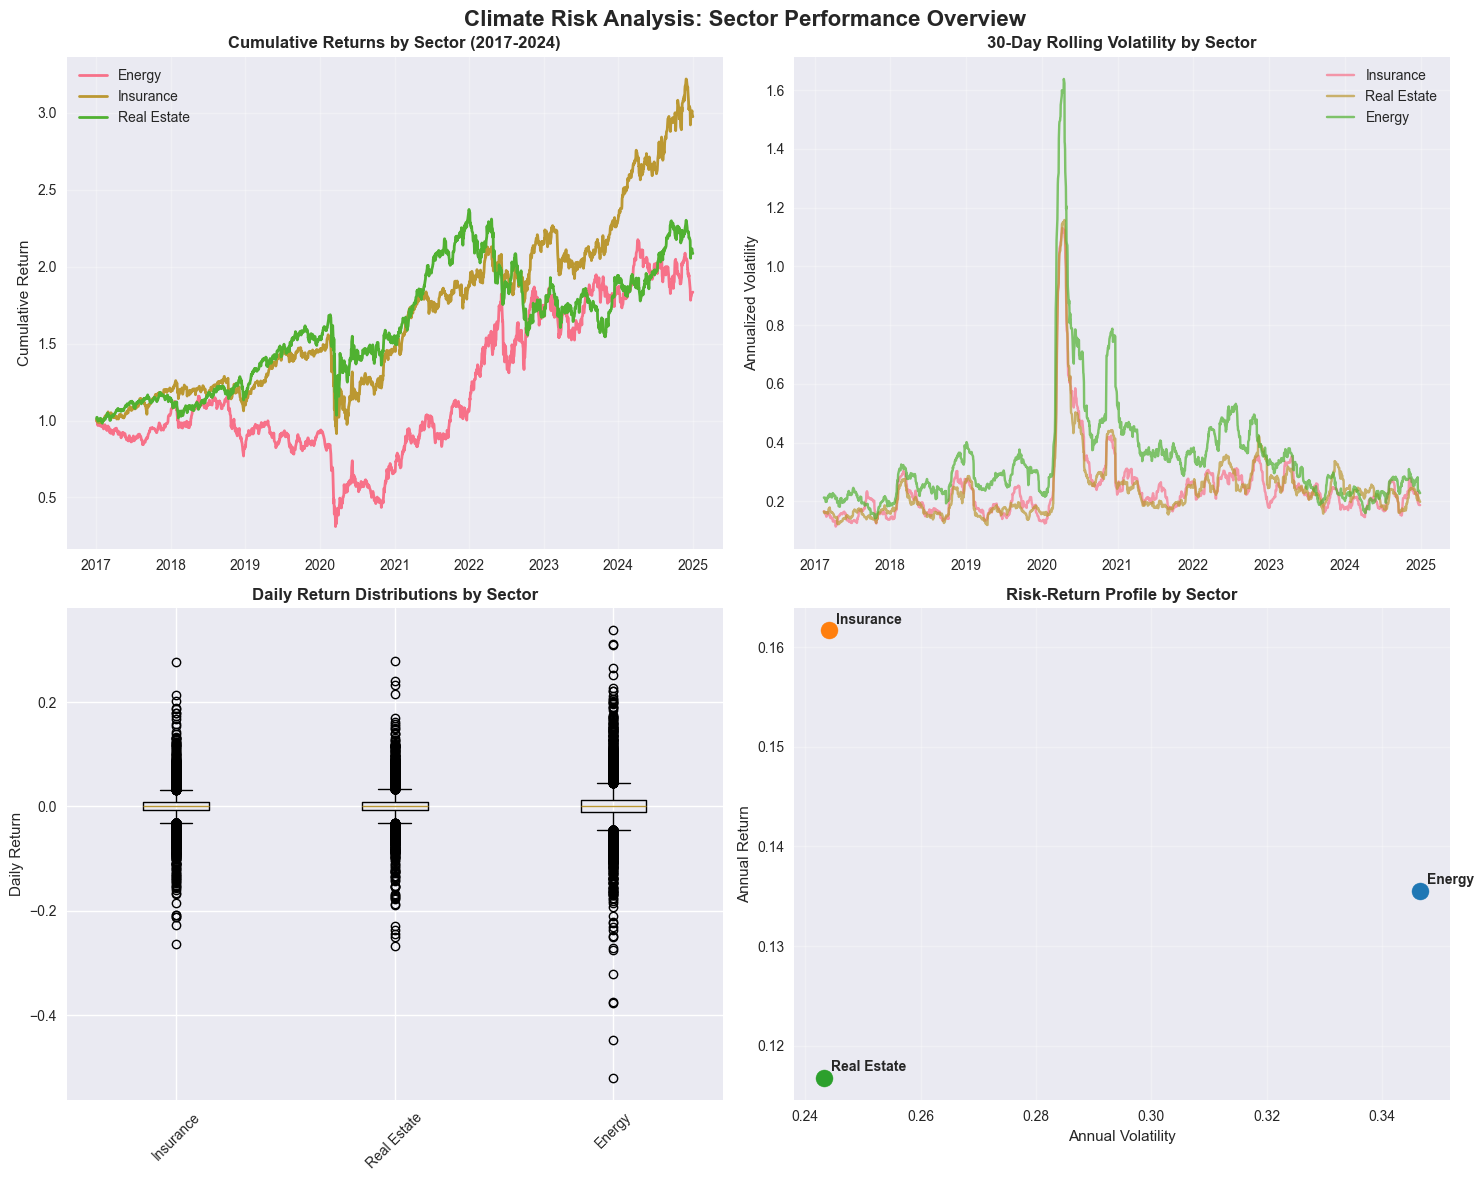

Sector overview visualizations created


In [10]:
print("Creating visualizations...")
fig, axes = plt.subplots(2, 2, figsize=(15, 12)) # Setting up the plotting environment
fig.suptitle('Climate Risk Analysis: Sector Performance Overview', fontsize=16, fontweight='bold')
sector_returns = df.groupby(['Date', 'Sector'])['Daily_Return'].mean().reset_index() # Calculating sector-level daily returns for visualization
sector_pivot = sector_returns.pivot(index='Date', columns='Sector', values='Daily_Return')
sector_cumulative = (1 + sector_pivot.fillna(0)).cumprod()

# Viz 1. Sector Cumulative Returns
ax1 = axes[0, 0]
for sector in sector_cumulative.columns:
    ax1.plot(sector_cumulative.index, sector_cumulative[sector], label=sector, linewidth=2)
ax1.set_title('Cumulative Returns by Sector (2017-2024)', fontweight='bold')
ax1.set_ylabel('Cumulative Return')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Viz 2. Rolling Volatility by Sector  
ax2 = axes[0, 1]
volatility_data = df.groupby(['Date', 'Sector'])['Volatility_30d'].mean().reset_index()
for sector in df['Sector'].unique():
    sector_vol = volatility_data[volatility_data['Sector'] == sector]
    ax2.plot(sector_vol['Date'], sector_vol['Volatility_30d'], label=sector, alpha=0.7)
ax2.set_title('30-Day Rolling Volatility by Sector', fontweight='bold')
ax2.set_ylabel('Annualized Volatility')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Viz 3. Return Distribution by Sector
ax3 = axes[1, 0]
sector_data_for_box = []
sector_labels = []
for sector in df['Sector'].unique():
    sector_returns = df[df['Sector'] == sector]['Daily_Return'].dropna()
    sector_data_for_box.append(sector_returns)
    sector_labels.append(sector)
ax3.boxplot(sector_data_for_box, labels=sector_labels)
ax3.set_title('Daily Return Distributions by Sector', fontweight='bold')
ax3.set_ylabel('Daily Return')
ax3.tick_params(axis='x', rotation=45)

# Viz 4. Risk-Return Profile
ax4 = axes[1, 1]
risk_return_data = df.groupby('Sector').agg({'Daily_Return': 'mean','Volatility_30d': 'mean'}).reset_index()
risk_return_data['Annual_Return'] = risk_return_data['Daily_Return'] * 252
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, sector in enumerate(risk_return_data['Sector']):
    row = risk_return_data[risk_return_data['Sector'] == sector].iloc[0]
    ax4.scatter(row['Volatility_30d'], row['Annual_Return'], 
               s=150, label=sector, color=colors[i])
    ax4.annotate(sector, (row['Volatility_30d'], row['Annual_Return']),
                xytext=(5, 5), textcoords='offset points', fontweight='bold')

ax4.set_title('Risk-Return Profile by Sector', fontweight='bold')
ax4.set_xlabel('Annual Volatility')
ax4.set_ylabel('Annual Return')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Sector overview visualizations created")

Creating climate event impact visualizations...


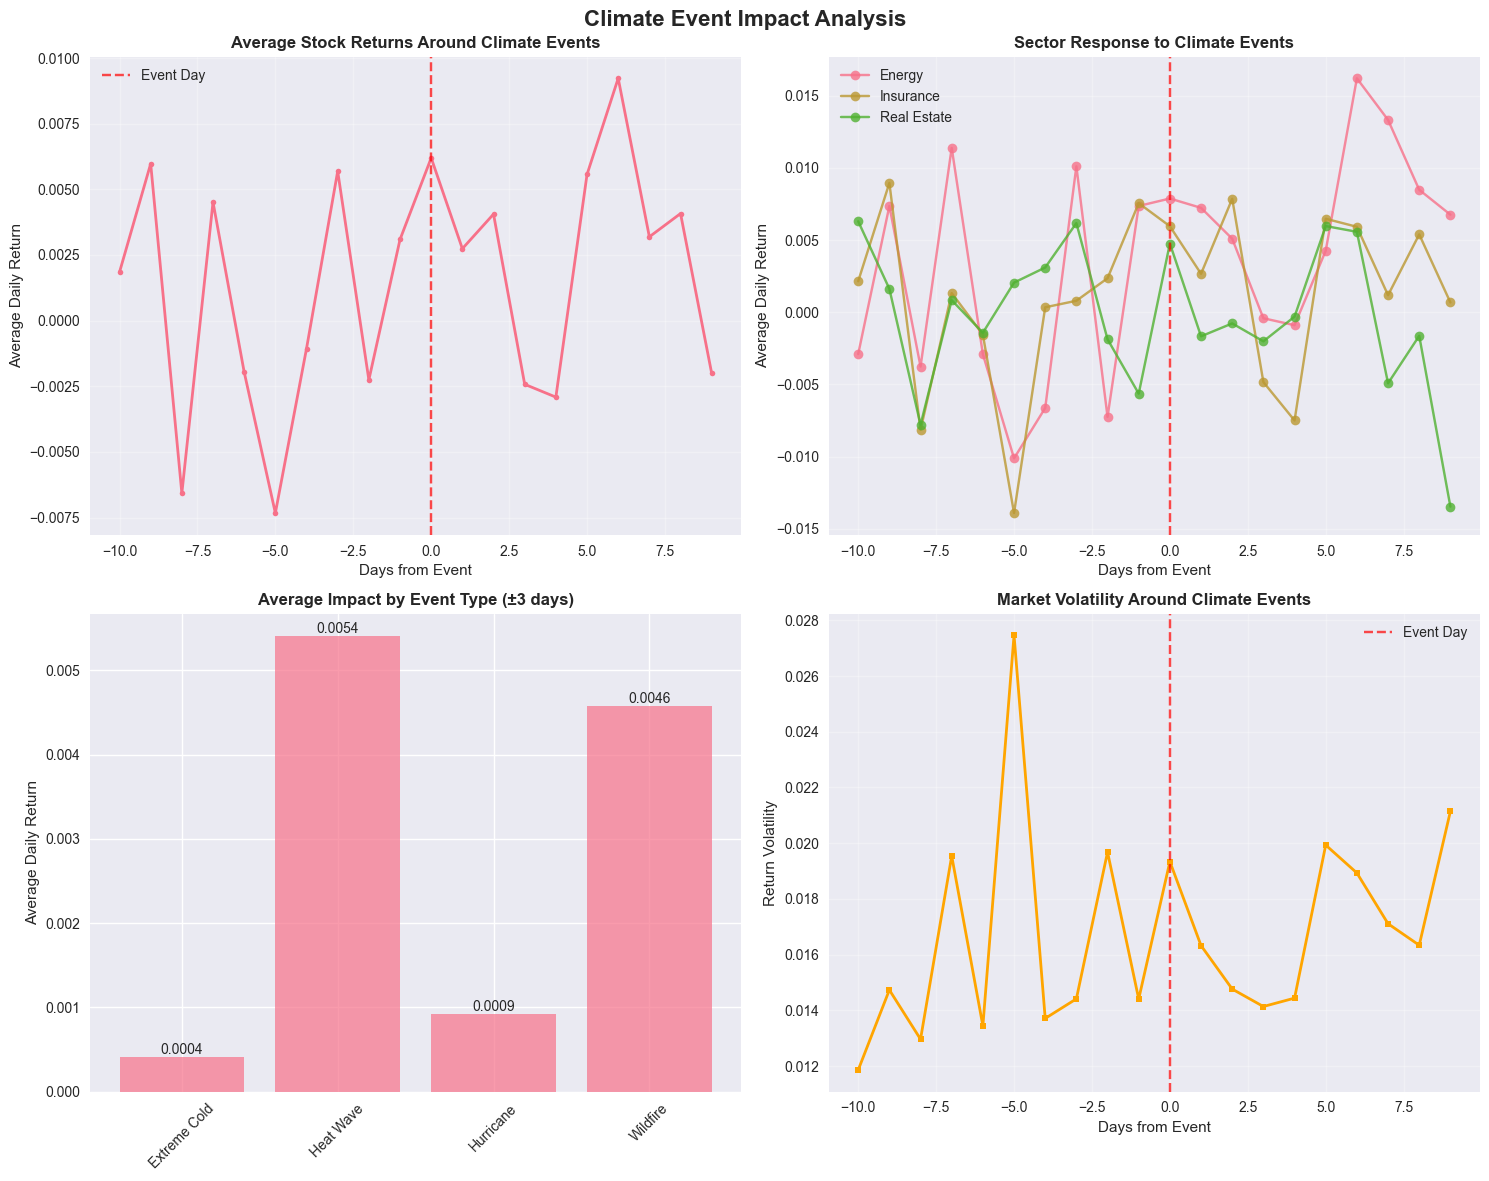

Climate event visualizations created


In [11]:
if 'event_analysis_df' in locals():
    print("Creating climate event impact visualizations...")
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Climate Event Impact Analysis', fontsize=16, fontweight='bold')
    
    # Viz 1. Average returns around events
    ax1 = axes[0, 0]
    event_timeline = event_analysis_df.groupby('Days_from_Event')['Daily_Return'].mean()
    ax1.plot(event_timeline.index, event_timeline.values, 'o-', linewidth=2, markersize=4)
    ax1.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Event Day')
    ax1.set_title('Average Stock Returns Around Climate Events', fontweight='bold')
    ax1.set_xlabel('Days from Event')
    ax1.set_ylabel('Average Daily Return')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Viz 2. Sector response to events
    ax2 = axes[0, 1]
    sector_event_response = event_analysis_df.groupby(['Days_from_Event', 'Sector'])['Daily_Return'].mean().unstack()
    for sector in sector_event_response.columns:
        ax2.plot(sector_event_response.index, sector_event_response[sector], 
                'o-', label=sector, alpha=0.8)
    ax2.axvline(x=0, color='red', linestyle='--', alpha=0.7)
    ax2.set_title('Sector Response to Climate Events', fontweight='bold')
    ax2.set_xlabel('Days from Event')
    ax2.set_ylabel('Average Daily Return')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Viz 3. Event type comparison
    ax3 = axes[1, 0]
    event_type_impact = event_analysis_df[event_analysis_df['Days_from_Event'].between(-3, 3)].groupby('Event_Type')['Daily_Return'].mean()
    bars = ax3.bar(event_type_impact.index, event_type_impact.values, alpha=0.7)
    ax3.set_title('Average Impact by Event Type (±3 days)', fontweight='bold')
    ax3.set_ylabel('Average Daily Return')
    ax3.tick_params(axis='x', rotation=45)
    for bar in bars:  # Add value labels on bars
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom')
    
    # Viz 4. Volatility around events
    ax4 = axes[1, 1]
    event_volatility = event_analysis_df.groupby('Days_from_Event')['Daily_Return'].std()
    ax4.plot(event_volatility.index, event_volatility.values, 's-', 
            color='orange', linewidth=2, markersize=4)
    ax4.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Event Day')
    ax4.set_title('Market Volatility Around Climate Events', fontweight='bold')
    ax4.set_xlabel('Days from Event')
    ax4.set_ylabel('Return Volatility')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("Climate event visualizations created")
else:
    print("No event data available for visualization")